# NLP & representation learning: Neural Embeddings, Text Classification


To use statistical classifiers with text, it is first necessary to vectorize the text. In the first practical session we explored the **Bag of Word (BoW)** model. 

Modern **state of the art** methods uses  embeddings to vectorize the text before classification in order to avoid feature engineering.

## [Dataset](https://thome.isir.upmc.fr/classes/RITAL/json_pol.json)


## "Modern" NLP pipeline

By opposition to the **bag of word** model, in the modern NLP pipeline everything is **embeddings**. Instead of encoding a text as a **sparse vector** of length $D$ (size of feature dictionnary) the goal is to encode the text in a meaningful dense vector of a small size $|e| <<< |D|$. 


The raw classification pipeline is then the following:

```
raw text ---|embedding table|-->  vectors --|Neural Net|--> class 
```


### Using a  language model:

How to tokenize the text and extract a feature dictionnary is still a manual task. To directly have meaningful embeddings, it is common to use a pre-trained language model such as `word2vec` which we explore in this practical.

In this setting, the pipeline becomes the following:
```
      
raw text ---|(pre-trained) Language Model|--> vectors --|classifier (or fine-tuning)|--> class 
```


- #### Classic word embeddings

 - [Word2Vec](https://arxiv.org/abs/1301.3781)
 - [Glove](https://nlp.stanford.edu/projects/glove/)


- #### bleeding edge language models techniques (see next)

 - [UMLFIT](https://arxiv.org/abs/1801.06146)
 - [ELMO](https://arxiv.org/abs/1802.05365)
 - [GPT](https://blog.openai.com/language-unsupervised/)
 - [BERT](https://arxiv.org/abs/1810.04805)






### Goal of this session:

1. Train word embeddings on training dataset
2. Tinker with the learnt embeddings and see learnt relations
3. Tinker with pre-trained embeddings.
4. Use those embeddings for classification
5. Compare different embedding models

## STEP 0: Loading data 

In [2]:
import json
from collections import Counter

# Loading json
file = './datasets/json_pol.json'
with open(file,encoding="utf-8") as f:
    data = json.load(f)

print(data[0])

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old Justin Henry and a script that was sympathetic to each character (and each one\'s predicament), the thought provoking elements linger long after the tear jerking ones are over. Overall, superior acting from a solid cast, excellent directing, and a very powerful script. The right touches of humor throughout help keep a "heavy" subject from becoming tedious or difficult to sit through. Lastly, this film stands the test of time and seems in no way dated, decades after it was released.', 1]


In [3]:
# Nombre total de revues
num_reviews = len(data)

# Comptage des revues positives et négatives
counter = Counter((x[1] for x in data))
num_positive_reviews = counter[1]
num_negative_reviews = counter[0]

# Calcul du pourcentage de revues positives et négatives
percentage_positive_reviews = (num_positive_reviews / num_reviews) * 100
percentage_negative_reviews = (num_negative_reviews / num_reviews) * 100

# Affichage des statistiques
print("----------------------------------------------------------")
print("Nombre total de revues : ", num_reviews)
print("Nombre de revues positives : ", num_positive_reviews)
print("Nombre de revues négatives : ", num_negative_reviews)
print("Pourcentage de revues positives : {:.2f}%".format(percentage_positive_reviews))
print("Pourcentage de revues négatives : {:.2f}%".format(percentage_negative_reviews))
print("----------------------------------------------------------")

----------------------------------------------------------
Nombre total de revues :  25000
Nombre de revues positives :  12500
Nombre de revues négatives :  12500
Pourcentage de revues positives : 50.00%
Pourcentage de revues négatives : 50.00%
----------------------------------------------------------


In [4]:
# Split the data into train set and test set
import random

random.shuffle(data)  # Mélange aléatoire des revues

split_index = int(len(data) * 0.8)  # 80% pour l'entraînement, 20% pour le test

data_train = data[:split_index]  # Ensemble de données d'entraînement
data_test = data[split_index:]  # Ensemble de données de test

print("Taille de data_train :", len(data_train))
print("Taille de data_test :", len(data_test))


Taille de data_train : 20000
Taille de data_test : 5000


In [5]:
# Nombre total de revues
num_reviews = len(data_train)

# Comptage des revues positives et négatives
counter = Counter((x[1] for x in data_train))
num_positive_reviews = counter[1]
num_negative_reviews = counter[0]

# Calcul du pourcentage de revues positives et négatives
percentage_positive_reviews = (num_positive_reviews / num_reviews) * 100
percentage_negative_reviews = (num_negative_reviews / num_reviews) * 100

# Affichage des statistiques
print("----------------------------------------------------------")
print("Train set")
print("Nombre total de revues : ", num_reviews)
print("Nombre de revues positives : ", num_positive_reviews)
print("Nombre de revues négatives : ", num_negative_reviews)
print("Pourcentage de revues positives : {:.2f}%".format(percentage_positive_reviews))
print("Pourcentage de revues négatives : {:.2f}%".format(percentage_negative_reviews))
print("----------------------------------------------------------")

----------------------------------------------------------
Train set
Nombre total de revues :  20000
Nombre de revues positives :  9960
Nombre de revues négatives :  10040
Pourcentage de revues positives : 49.80%
Pourcentage de revues négatives : 50.20%
----------------------------------------------------------


In [6]:
# Nombre total de revues
num_reviews = len(data_test)

# Comptage des revues positives et négatives
counter = Counter((x[1] for x in data_test))
num_positive_reviews = counter[1]
num_negative_reviews = counter[0]

# Calcul du pourcentage de revues positives et négatives
percentage_positive_reviews = (num_positive_reviews / num_reviews) * 100
percentage_negative_reviews = (num_negative_reviews / num_reviews) * 100

# Affichage des statistiques
print("----------------------------------------------------------")
print("Test set")
print("Nombre total de revues : ", num_reviews)
print("Nombre de revues positives : ", num_positive_reviews)
print("Nombre de revues négatives : ", num_negative_reviews)
print("Pourcentage de revues positives : {:.2f}%".format(percentage_positive_reviews))
print("Pourcentage de revues négatives : {:.2f}%".format(percentage_negative_reviews))
print("----------------------------------------------------------")

----------------------------------------------------------
Test set
Nombre total de revues :  5000
Nombre de revues positives :  2540
Nombre de revues négatives :  2460
Pourcentage de revues positives : 50.80%
Pourcentage de revues négatives : 49.20%
----------------------------------------------------------


In [7]:
import string
import re

def preprocess(text):
    text = re.sub('[0-9]+', '', text)
    punc = string.punctuation 
    punc += '\n\r\t'
    return text.translate(str.maketrans(punc, ' ' * len(punc)))



In [8]:
# preprocess the data
data = [(preprocess(rev),y) for (rev,y) in data]

## Word2Vec: Quick Recap

**[Word2Vec](https://arxiv.org/abs/1301.3781) is composed of two distinct language models (CBOW and SG), optimized to quickly learn word vectors**


given a random text: `i'm taking the dog out for a walk`



### (a) Continuous Bag of Word (CBOW)
    -  predicts a word given a context
    
maximizing `p(dog | i'm taking the ___ out for a walk)`
    
### (b) Skip-Gram (SG)               
    -  predicts a context given a word
    
 maximizing `p(i'm taking the out for a walk | dog)`



   

## STEP 1: train a language model (word2vec)

Gensim has one of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) fastest implementation.


### Train:

In [9]:
# if gensim not installed yet
# ! pip install gensim

In [10]:
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

text = [t.split() for t,p in data]

# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1, epochs=5)

2024-03-01 01:47:20,635 : INFO : collecting all words and their counts
2024-03-01 01:47:20,636 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-01 01:47:20,889 : INFO : PROGRESS: at sentence #10000, processed 2368049 words, keeping 62336 word types
2024-03-01 01:47:21,133 : INFO : PROGRESS: at sentence #20000, processed 4700729 words, keeping 84054 word types
2024-03-01 01:47:21,269 : INFO : collected 92579 word types from a corpus of 5886569 raw words and 25000 sentences
2024-03-01 01:47:21,270 : INFO : Creating a fresh vocabulary
2024-03-01 01:47:21,345 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 32724 unique words (35.35% of original 92579, drops 59855)', 'datetime': '2024-03-01T01:47:21.345403', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
2024-03-01 01:47:21,345 : INFO : Word2Vec lifecy

In [11]:
# Worth it to save the previous embedding
w2v.save("W2v-movies.dat")
# You will be able to reload them:
# w2v = gensim.models.Word2Vec.load("W2v-movies.dat")
# and you can continue the learning process if needed

2024-03-01 01:47:56,975 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'W2v-movies.dat', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-03-01T01:47:56.975507', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2024-03-01 01:47:56,976 : INFO : not storing attribute cum_table
2024-03-01 01:47:57,629 : INFO : saved W2v-movies.dat


## STEP 2: Test learnt embeddings

The word embedding space directly encodes similarities between words: the vector coding for the word "great" will be closer to the vector coding for "good" than to the one coding for "bad". Generally, [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is the distance used when considering distance between vectors.

KeyedVectors have a built in [similarity](https://radimrehurek.com/gensim/models /keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.similarity) method to compute the cosine similarity between words

In [12]:
# is great really closer to good than to bad ?
print("great and good:",w2v.wv.similarity("great","good"))
print("great and bad:",w2v.wv.similarity("great","bad"))

great and good: 0.7858629
great and bad: 0.5590532


<font color='bleu'>Le score de similarité de "great" et "good" suggère une forte similarité entre ces deux mots. Cela est cohérent ils ont des significations similaires et sont souvent utilisés de manière interchangeable dans des contextes positifs.


Le score de similarité de "great" et "bad" suggère une similarité plus faible entre ces deux mots. Cela est également cohérent car "great" et "bad" ont des significations opposées et sont utilisés dans des contextes contrastés.<font>

In [13]:
print("king and queen:",w2v.wv.similarity("king","queen"))
print("king and book:",w2v.wv.similarity("king","book"))

king and queen: 0.4788258
king and book: 0.17684744


<font color='bleu'>Le score de similarité de "king" et "queen" suggère une similarité modérée entre ces deux mots. Cela est cohérent car "king" et "queen" sont tous deux des termes de la royauté, ils partagent  donc un certain degré de sémantique commune.

Le score de similarité de "king" et "book" est très faible car ils ont des significations complètement différentes.<font>

In [14]:
print("cat and dog:",w2v.wv.similarity("cat","dog"))

cat and dog: 0.67913896


<font color='bleu'>
"cat" et "dog" sont tous deux des animaux domestiques courants et partagent de nombreuses caractéristiques similaires donc ils ont un score de similarité élevé
<font>

In [15]:
print("happy and sad:",w2v.wv.similarity("happy","sad"))

happy and sad: 0.59650314


<font color="bleu">"happy" et "sad" sont tous deux des états émotionnels opposés, les deux mots sont alors lié sémantiquement, ils ont donc un score de similarité élevé<font>

In [16]:
print("food and foot:",w2v.wv.similarity("food","foot"))

food and foot: 0.43706667


<font color="bleu">Malgré la resemblense syntaxique les deux mots n'ont pas de relation sématntique, le score de similarité est donc faible<font>

In [17]:
print("take and taking:",w2v.wv.similarity("take","taking"))

take and taking: 0.71834826


<font color="bleu">"take" et "taking" sont des formes différentes du même verbe et partagent une racine lexicale commune donc ils ont un score de similarité trés élevé<font>

Since cosine distance encodes similarity, neighboring words are supposed to be similar. The [most_similar](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.most_similar) method returns the `topn` words given a query.

In [18]:
# The query can be as simple as a word, such as "movie"

# Try changing the word
for word in ['movie', 'good', 'bad', 'review']:
    print(word, ':')
    for item in w2v.wv.most_similar(word,topn=5):
        print('\t', item)
    print('     ------------------------------------------------ ')

movie :
	 ('film', 0.9136845469474792)
	 ('flick', 0.7748123407363892)
	 ('Interferencia', 0.7579891681671143)
	 ('Noroi', 0.7405137419700623)
	 ('Bled', 0.7349605560302734)
     ------------------------------------------------ 
good :
	 ('decent', 0.7951734662055969)
	 ('great', 0.785862922668457)
	 ('bad', 0.7551313042640686)
	 ('nice', 0.7308067679405212)
	 ('serviceable', 0.7278130650520325)
     ------------------------------------------------ 
bad :
	 ('horrible', 0.7889100909233093)
	 ('terrible', 0.7846826314926147)
	 ('awful', 0.7651911973953247)
	 ('good', 0.7551313638687134)
	 ('lousy', 0.7325114607810974)
     ------------------------------------------------ 
review :
	 ('comment', 0.8491536974906921)
	 ('user', 0.7517848014831543)
	 ('posted', 0.7517282962799072)
	 ('reviews', 0.7436370849609375)
	 ('IMDb', 0.7427393794059753)
     ------------------------------------------------ 


But it can be a more complicated query
Word embedding spaces tend to encode much more.

The most famous exemple is: `vec(king) - vec(man) + vec(woman) => vec(queen)`

In [19]:
# What is awesome - good + bad?
result = w2v.wv.most_similar(positive=["awesome", "bad"], negative=["good"], topn=3)
print("Result for 'awesome - good + bad':")
for word, similarity in result:
    print(f"\t{word}: {similarity}")
print('     ------------------------------------------------ \n')

# actor - man + woman
result = w2v.wv.most_similar(positive=["actor", "woman"], negative=["man"], topn=3)
print("Result for 'actor - man + woman':")
for word, similarity in result:
    print(f"\t{word}: {similarity}")
print('     ------------------------------------------------ \n')

# Trying plurals
result = w2v.wv.most_similar(positive=["films"], negative=["film"], topn=3)
print("Most similar words to 'films':")
for word, similarity in result:
    print(f"\t{word}: {similarity}")

Result for 'awesome - good + bad':
	awful: 0.8031883239746094
	terrible: 0.6850028038024902
	horrible: 0.665641725063324
     ------------------------------------------------ 

Result for 'actor - man + woman':
	actress: 0.8561328649520874
	performer: 0.6743024587631226
	thespian: 0.6726702451705933
     ------------------------------------------------ 

Most similar words to 'films':
	classics: 0.35336798429489136
	shorts: 0.3504573702812195
	movies: 0.34843581914901733


**To test learnt "synctactic" and "semantic" similarities, Mikolov et al. introduced a special dataset containing a wide variety of three way similarities.**

**You can download the dataset [here](https://thome.isir.upmc.fr/classes/RITAL/questions-words.txt).**

In [20]:
out = w2v.wv.evaluate_word_analogies("ressources/questions-words.txt",case_insensitive=True)  #original semantic syntactic dataset.

2024-03-01 01:47:57,736 : INFO : Evaluating word analogies for top 300000 words in the model on ressources/questions-words.txt
2024-03-01 01:47:57,846 : INFO : capital-common-countries: 7.1% (11/156)
2024-03-01 01:47:57,945 : INFO : capital-world: 4.9% (7/144)
2024-03-01 01:47:57,965 : INFO : currency: 0.0% (0/28)


2024-03-01 01:47:58,298 : INFO : city-in-state: 1.1% (6/553)
2024-03-01 01:47:58,488 : INFO : family: 35.3% (134/380)
2024-03-01 01:47:58,931 : INFO : gram1-adjective-to-adverb: 2.0% (19/930)
2024-03-01 01:47:59,267 : INFO : gram2-opposite: 3.2% (21/650)
2024-03-01 01:47:59,957 : INFO : gram3-comparative: 26.8% (338/1260)
2024-03-01 01:48:00,348 : INFO : gram4-superlative: 10.3% (72/702)
2024-03-01 01:48:00,777 : INFO : gram5-present-participle: 19.8% (161/812)
2024-03-01 01:48:01,278 : INFO : gram6-nationality-adjective: 4.4% (45/1030)
2024-03-01 01:48:01,936 : INFO : gram7-past-tense: 15.8% (211/1332)
2024-03-01 01:48:02,412 : INFO : gram8-plural: 7.2% (76/1056)
2024-03-01 01:48:02,765 : INFO : gram9-plural-verbs: 28.6% (216/756)
2024-03-01 01:48:02,766 : INFO : Quadruplets with out-of-vocabulary words: 49.9%
2024-03-01 01:48:02,766 : INFO : NB: analogies containing OOV words were skipped from evaluation! To change this behavior, use "dummy4unknown=True"
2024-03-01 01:48:02,767 : INF

**When training the w2v models on the review dataset, since it hasn't been learnt with a lot of data, it does not perform very well.**


## STEP 3: Loading a pre-trained model

In Gensim, embeddings are loaded and can be used via the ["KeyedVectors"](https://radimrehurek.com/gensim/models/keyedvectors.html) class

> Since trained word vectors are independent from the way they were trained (Word2Vec, FastText, WordRank, VarEmbed etc), they can be represented by a standalone structure, as implemented in this module.

>The structure is called “KeyedVectors” and is essentially a mapping between entities and vectors. Each entity is identified by its string id, so this is a mapping between {str => 1D numpy array}.

>The entity typically corresponds to a word (so the mapping maps words to 1D vectors), but for some models, they key can also correspond to a document, a graph node etc. To generalize over different use-cases, this module calls the keys entities. Each entity is always represented by its string id, no matter whether the entity is a word, a document or a graph node.

**You can download the pre-trained word embedding [HERE](https://thome.isir.upmc.fr/classes/RITAL/word2vec-google-news-300.dat) .**

In [21]:
from gensim.test.utils import get_tmpfile
import gensim.downloader as api
bload = True
fname = "word2vec-google-news-300"
sdir = "" # Change

if(bload==True):
    wv_pre_trained = gensim.models.KeyedVectors.load(sdir+fname+".dat")
else:    
    wv_pre_trained = api.load(fname)
    wv_pre_trained.save(sdir+fname+".dat")
    

2024-03-01 01:48:02,786 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-03-01 01:48:02,787 : INFO : built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)
2024-03-01 01:48:02,787 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)", 'datetime': '2024-03-01T01:48:02.787673', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


2024-03-01 01:48:02,848 : INFO : loading KeyedVectors object from word2vec-google-news-300.dat
2024-03-01 01:48:05,703 : INFO : loading vectors from word2vec-google-news-300.dat.vectors.npy with mmap=None
2024-03-01 01:48:51,372 : INFO : KeyedVectors lifecycle event {'fname': 'word2vec-google-news-300.dat', 'datetime': '2024-03-01T01:48:51.372992', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}


In [22]:
print("great and good:",wv_pre_trained.similarity("great","good"))
print("great and bad:",wv_pre_trained.similarity("great","bad"))

great and good: 0.729151
great and bad: 0.3928765


In [23]:
print("king and queen:",wv_pre_trained.similarity("king","queen"))
print("king and book:",wv_pre_trained.similarity("king","book"))

king and queen: 0.6510957
king and book: 0.047840133


In [24]:
print("cat and dog:",wv_pre_trained.similarity("cat","dog"))

cat and dog: 0.76094574


In [25]:
# The query can be as simple as a word, such as "movie"

# Try changing the word
for word in ['movie', 'good', 'bad', 'review']:
    print(word, ':')
    for item in wv_pre_trained.most_similar(word,topn=5):
        print('\t', item)
    print('     ------------------------------------------------ ')

movie :
	 ('film', 0.8676770329475403)
	 ('movies', 0.8013108372688293)
	 ('films', 0.7363011837005615)
	 ('moive', 0.6830360889434814)
	 ('Movie', 0.6693680286407471)
     ------------------------------------------------ 
good :
	 ('great', 0.7291510105133057)
	 ('bad', 0.7190051078796387)
	 ('terrific', 0.6889115571975708)
	 ('decent', 0.6837348341941833)
	 ('nice', 0.6836092472076416)
     ------------------------------------------------ 
bad :
	 ('good', 0.7190051674842834)
	 ('terrible', 0.6828612089157104)
	 ('horrible', 0.6702597737312317)
	 ('Bad', 0.669891893863678)
	 ('lousy', 0.6647640466690063)
     ------------------------------------------------ 
review :
	 ('reviewed', 0.6630409359931946)
	 ('reviewing', 0.6609557271003723)
	 ('reviews', 0.6379557251930237)
	 ('evaluation', 0.6035540699958801)
	 ('assessment', 0.533311128616333)
     ------------------------------------------------ 


In [26]:
# What is awesome - good + bad?
result = wv_pre_trained.most_similar(positive=["awesome", "bad"], negative=["good"], topn=3)
print("Result for 'awesome - good + bad':")
for word, similarity in result:
    print(f"\t{word}: {similarity}")
print('     ------------------------------------------------ \n')

# actor - man + woman
result = wv_pre_trained.most_similar(positive=["actor", "woman"], negative=["man"], topn=3)
print("Result for 'actor - man + woman':")
for word, similarity in result:
    print(f"\t{word}: {similarity}")
print('     ------------------------------------------------ \n')

# Trying plurals
result = wv_pre_trained.most_similar(positive=["films"], negative=["film"], topn=3)
print("Most similar words to 'films':")
for word, similarity in result:
    print(f"\t{word}: {similarity}")

Result for 'awesome - good + bad':
	horrible: 0.5953484177589417
	amazing: 0.5928210020065308
	weird: 0.5782381296157837
     ------------------------------------------------ 

Result for 'actor - man + woman':
	actress: 0.8602624535560608
	actresses: 0.6596670150756836
	thesp: 0.6290916800498962
     ------------------------------------------------ 

Most similar words to 'films':
	voluntourism_trips: 0.3497668504714966
	brands_Wrigley_Spearmint: 0.34150567650794983
	Marco_Olivieri: 0.33528149127960205


In [29]:
out = wv_pre_trained.evaluate_word_analogies("ressources/questions-words.txt",case_insensitive=True)  #original semantic syntactic dataset.

2024-03-01 01:50:10,231 : INFO : Evaluating word analogies for top 300000 words in the model on ressources/questions-words.txt
2024-03-01 01:50:15,968 : INFO : capital-common-countries: 83.2% (421/506)
2024-03-01 01:51:05,133 : INFO : capital-world: 81.3% (3552/4368)
2024-03-01 01:51:14,172 : INFO : currency: 28.5% (230/808)
2024-03-01 01:51:43,931 : INFO : city-in-state: 72.1% (1779/2467)
2024-03-01 01:51:50,112 : INFO : family: 86.2% (436/506)
2024-03-01 01:52:02,922 : INFO : gram1-adjective-to-adverb: 29.2% (290/992)
2024-03-01 01:52:12,455 : INFO : gram2-opposite: 43.5% (353/812)
2024-03-01 01:52:27,738 : INFO : gram3-comparative: 91.3% (1216/1332)
2024-03-01 01:52:40,531 : INFO : gram4-superlative: 88.0% (987/1122)
2024-03-01 01:52:52,495 : INFO : gram5-present-participle: 78.5% (829/1056)
2024-03-01 01:53:11,849 : INFO : gram6-nationality-adjective: 90.2% (1442/1599)
2024-03-01 01:53:30,027 : INFO : gram7-past-tense: 65.4% (1020/1560)
2024-03-01 01:53:45,041 : INFO : gram8-plural

## Perform the "synctactic" and "semantic" evaluations on w2v (the trained model) and wv_pre_trained (the pretrained model)

To compare the performance of the two Word2Vec models, one trained (w2v) and one using pre-trained embeddings (w2v_pretrained), we will expand the analogy dataset and evaluate both models. 

In [30]:
# Perform syntactic evaluation using analogy task
def evaluate_syntactic():
    analogy_dataset = [
        ("man", "woman", "king", "queen"),
        ("good", "better", "bad", "worse"),
        ("run", "ran", "eat", "ate"),
        ("movie", "actor", "book", "author"),  
        ("cinema", "screen", "theater", "stage"), 
        ("director", "film", "conductor", "orchestra"),  
        ("plot", "story", "character", "role"), 
        ("positive", "negative", "uplifting", "depressing"),  
        ("entertaining", "boring", "engaging", "tedious"), 
        ("blockbuster", "hit", "flop", "failure")
    ]
    correct_count_w2v = 0
    correct_count_w2v_pretrained = 0
    total_count = 0

    for word1, word2, word3, expected_word in analogy_dataset:
        # Predict the word using the w2v model
        predicted_word_w2v = w2v.wv.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0]
        
        # Predict the word using the wv_pre_trained model
        predicted_word_w2v_pretrained = wv_pre_trained.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0]
        
        # Compare the predicted word with the expected word
        if predicted_word_w2v == expected_word:
            correct_count_w2v += 1
        if predicted_word_w2v_pretrained == expected_word:
            correct_count_w2v_pretrained += 1
        total_count += 1

    accuracy_w2v = correct_count_w2v / total_count * 100
    accuracy_w2v_pretrained = correct_count_w2v_pretrained / total_count * 100
    
    print(f"Syntactic Evaluation Accuracy (w2v): {accuracy_w2v}%")
    print(f"Syntactic Evaluation Accuracy (w2v_pretrained): {accuracy_w2v_pretrained}%")

# Call the syntactic evaluation function
evaluate_syntactic()

Syntactic Evaluation Accuracy (w2v): 20.0%
Syntactic Evaluation Accuracy (w2v_pretrained): 50.0%


<font color="bleu">On remarque que le modèle pré entrainé a une meilleure performance dans la capture des relations syntaxiques.<font>

## STEP 4:  sentiment classification

In the previous practical session, we used a bag of word approach to transform text into vectors.
Here, we propose to try to use word vectors (previously learnt or loaded).


### <font color='green'> Since we have only word vectors and that sentences are made of multiple words, we need to aggregate them. </font>


### (1) Vectorize reviews using word vectors:

Word aggregation can be done in different ways:

- Sum
- Average
- Min/feature
- Max/feature

#### a few pointers:

- `w2v.wv.vocab` is a `set()` of the vocabulary (all existing words in your model)
- `np.minimum(a,b) and np.maximum(a,b)` respectively return element-wise min/max 

In [31]:
import numpy as np
# We first need to vectorize text:
# First we propose to a sum of them


def vectorize(text, f=np.sum, model=wv_pre_trained):
    """
    This function should vectorize one review

    input: str, numpy agregate function
    output: np.array(float)
    """    
    vec = []
    for word in preprocess(text):
        if word in model.key_to_index:
            vec.append(model[word])
    return f(vec, axis=0)

In [32]:
vectorize(data[0][0])

array([-180.61377   ,  125.69772   ,   -9.407532  ,  136.42526   ,
        -57.037354  ,   23.72882   , -103.59018   ,  -56.787354  ,
        -35.906616  ,   17.873009  ,  -59.80829   ,  -98.50315   ,
       -210.71542   ,   25.561592  , -129.56348   ,   94.42273   ,
         97.239555  ,  178.48315   ,  -14.685562  ,   10.491013  ,
       -260.21118   ,  -45.80992   ,  113.28873   ,   14.8782425 ,
        -81.385315  ,   22.742233  , -253.30713   ,   49.721344  ,
        -26.164124  ,  -27.384888  ,   -7.5142975 ,   32.07946   ,
        -76.347046  ,  -97.60849   , -129.97275   ,   92.69135   ,
       -227.27768   ,  116.26526   ,  -59.977177  ,   85.321655  ,
        -32.765076  ,  -43.760254  ,   62.93695   ,   81.394226  ,
         55.466064  ,  -39.47719   ,  -34.467033  , -178.81009   ,
       -123.29132   ,   82.13898   , -173.05042   ,  247.6564    ,
        -35.864014  ,  228.21887   ,   55.884766  ,  137.07678   ,
       -153.65967   , -110.57621   ,   -0.65795135, -166.09705

In [33]:
reviews_train = []
labels_train = []

for tuple in data_train:
    reviews_train.append(vectorize(tuple[0]))
    labels_train.append(tuple[1])


reviews_test = []
labels_test = []

for tuple in data_test:
    reviews_test.append(vectorize(tuple[0]))
    labels_test.append(tuple[1])

In [34]:
reviews_train[0]

array([-180.61377   ,  125.69772   ,   -9.407532  ,  136.42526   ,
        -57.037354  ,   23.72882   , -103.59018   ,  -56.787354  ,
        -35.906616  ,   17.873009  ,  -59.80829   ,  -98.50315   ,
       -210.71542   ,   25.561592  , -129.56348   ,   94.42273   ,
         97.239555  ,  178.48315   ,  -14.685562  ,   10.491013  ,
       -260.21118   ,  -45.80992   ,  113.28873   ,   14.8782425 ,
        -81.385315  ,   22.742233  , -253.30713   ,   49.721344  ,
        -26.164124  ,  -27.384888  ,   -7.5142975 ,   32.07946   ,
        -76.347046  ,  -97.60849   , -129.97275   ,   92.69135   ,
       -227.27768   ,  116.26526   ,  -59.977177  ,   85.321655  ,
        -32.765076  ,  -43.760254  ,   62.93695   ,   81.394226  ,
         55.466064  ,  -39.47719   ,  -34.467033  , -178.81009   ,
       -123.29132   ,   82.13898   , -173.05042   ,  247.6564    ,
        -35.864014  ,  228.21887   ,   55.884766  ,  137.07678   ,
       -153.65967   , -110.57621   ,   -0.65795135, -166.09705

In [35]:
labels_train

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,


In [36]:
reviews_test[0]

array([-4.94945129e+02,  3.37947784e+02, -1.08896484e+01,  3.63963348e+02,
       -1.59841492e+02,  5.22969666e+01, -2.75606689e+02, -1.52601929e+02,
       -1.10541382e+02,  7.13927460e+01, -1.51778503e+02, -2.59731140e+02,
       -5.87781982e+02,  6.42069397e+01, -3.55159668e+02,  2.58731201e+02,
        2.48861465e+02,  4.86240967e+02, -4.49515686e+01,  1.52008057e-01,
       -7.12680298e+02, -1.09377106e+02,  3.22696747e+02,  5.60811272e+01,
       -2.35314041e+02,  8.46033783e+01, -7.11694336e+02,  1.37772064e+02,
       -6.39309692e+01, -5.67132874e+01, -9.10662842e+00,  9.22985916e+01,
       -1.88847321e+02, -2.79439850e+02, -3.72105927e+02,  2.68523865e+02,
       -6.06121460e+02,  3.49158813e+02, -1.65384201e+02,  2.46264343e+02,
       -1.01161865e+02, -1.30701050e+02,  1.84907227e+02,  2.51160522e+02,
        1.49973114e+02, -1.01322090e+02, -9.55578003e+01, -4.89703766e+02,
       -3.29104980e+02,  2.16561523e+02, -4.77943420e+02,  6.72945312e+02,
       -8.04986572e+01,  

In [37]:
labels_test

[1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,


### (2) Train a classifier 
as in the previous practical session, train a logistic regression to do sentiment classification with word vectors



In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Scikit Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(reviews_train, labels_train)

labels_prediction = lr.predict(reviews_test)

# Calcul de l'exactitude
accuracy = accuracy_score(labels_prediction, labels_test)
print('Accuracy:', accuracy)

Accuracy: 0.634


C:\Users\Kadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# Rapport de classification
classification_rep = classification_report(labels_test, labels_prediction)
print('Classification report:')
print(classification_rep)

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      2460
           1       0.64      0.63      0.63      2540

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.63      5000



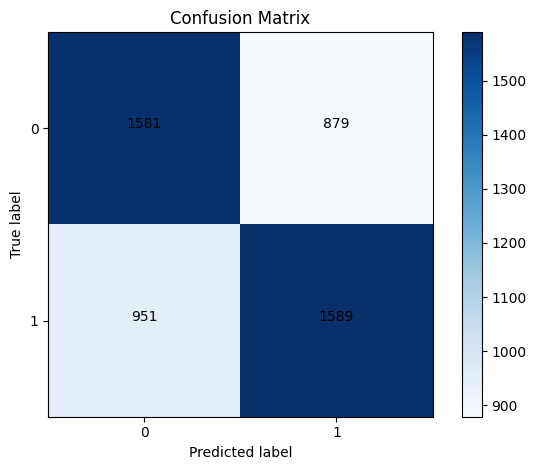

In [40]:
import matplotlib.pyplot as plt
# Compute the confusion matrix
confusion_mat = confusion_matrix(labels_test, labels_prediction)

# Define class labels
classes = [0, 1]

# Plot the confusion matrix
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = confusion_mat.max() / 2.
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="black" if confusion_mat[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

performance should be worst than with bag of word (~80%). Sum/Mean aggregation does not work well on long reviews (especially with many frequent words). This adds a lot of noise.

## **Todo**:  Try answering the following questions:

- Which word2vec model works best: skip-gram or cbow
- Do pretrained vectors work best than those learnt on the train dataset ?

## **Todo**: evaluate the same pipeline on speaker ID task (Chirac/Mitterrand) 


**(Bonus)** To have a better accuracy, we could try two things:
- Better aggregation methods (weight by tf-idf ?)
- Another word vectorizing method such as [fasttext](https://radimrehurek.com/gensim/models/fasttext.html)
- A document vectorizing method such as [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)

In [41]:
w2v_sg = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1, epochs=5)

2024-03-01 02:20:36,508 : INFO : collecting all words and their counts
2024-03-01 02:20:36,509 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-01 02:20:36,810 : INFO : PROGRESS: at sentence #10000, processed 2368049 words, keeping 62336 word types
2024-03-01 02:20:37,141 : INFO : PROGRESS: at sentence #20000, processed 4700729 words, keeping 84054 word types
2024-03-01 02:20:37,326 : INFO : collected 92579 word types from a corpus of 5886569 raw words and 25000 sentences
2024-03-01 02:20:37,326 : INFO : Creating a fresh vocabulary
2024-03-01 02:20:37,396 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 32724 unique words (35.35% of original 92579, drops 59855)', 'datetime': '2024-03-01T02:20:37.396370', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
2024-03-01 02:20:37,397 : INFO : Word2Vec lifecy

In [42]:
w2v_cbow = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=0, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1, epochs=5)

2024-03-01 02:21:19,015 : INFO : collecting all words and their counts
2024-03-01 02:21:19,016 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-01 02:21:19,258 : INFO : PROGRESS: at sentence #10000, processed 2368049 words, keeping 62336 word types
2024-03-01 02:21:19,515 : INFO : PROGRESS: at sentence #20000, processed 4700729 words, keeping 84054 word types
2024-03-01 02:21:19,659 : INFO : collected 92579 word types from a corpus of 5886569 raw words and 25000 sentences
2024-03-01 02:21:19,660 : INFO : Creating a fresh vocabulary
2024-03-01 02:21:19,738 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 32724 unique words (35.35% of original 92579, drops 59855)', 'datetime': '2024-03-01T02:21:19.738157', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
2024-03-01 02:21:19,739 : INFO : Word2Vec lifecy

In [80]:
f_names = ['sum', 'mean', 'min', 'max']
m_names = ['SG', 'CBOW', 'Pre_trained']

scores = np.zeros((4, 3))

for fi, f in enumerate([np.sum, np.mean, np.min, np.max]):
    for mi, m in enumerate([w2v_sg.wv, w2v_cbow.wv, wv_pre_trained]):
        reviews_train = []
        labels_train = []

        for tuple in data_train:
            reviews_train.append(vectorize(tuple[0],f,m))
            labels_train.append(tuple[1])


        reviews_test = []
        labels_test = []

        for tuple in data_test:
            reviews_test.append(vectorize(tuple[0],f,m))
            labels_test.append(tuple[1])
        
        lr = LogisticRegression(max_iter=1000)
        lr.fit(reviews_test, labels_test)

        labels_prediction = lr.predict(reviews_test)
        
        scores[fi, mi] = accuracy_score(labels_prediction, labels_test) 

C:\Users\Kadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

In [81]:
for fi in range(4):
    print(f_names[fi], " ---> ")
    for mi in range(3):
        print('\t', m_names[mi], ':', scores[fi, mi])
    
    print('--------------------------------------')

sum  ---> 
	 SG : 0.6394
	 CBOW : 0.6422
	 Pre_trained : 0.6368
--------------------------------------
mean  ---> 
	 SG : 0.5988
	 CBOW : 0.6066
	 Pre_trained : 0.6022
--------------------------------------
min  ---> 
	 SG : 0.5552
	 CBOW : 0.5368
	 Pre_trained : 0.5778
--------------------------------------
max  ---> 
	 SG : 0.5518
	 CBOW : 0.5402
	 Pre_trained : 0.5832
--------------------------------------


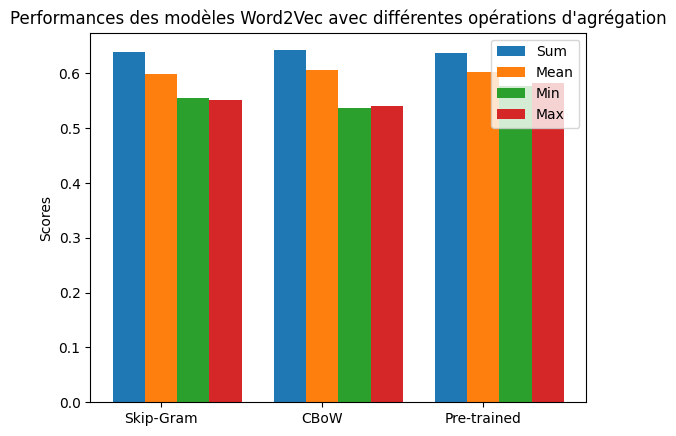

In [83]:
import matplotlib.pyplot as plt
import numpy as np

f_names = ['Sum', 'Mean', 'Min', 'Max']
m_names = ['Skip-Gram', 'CBoW', 'Pre-trained']

fig, ax = plt.subplots()

x = np.arange(len(m_names))
width = 0.2

for i, f_name in enumerate(f_names):
    ax.bar(x + i * width, scores[i, :], width, label=f_name)

ax.set_ylabel('Scores')
ax.set_title('Performances des modèles Word2Vec avec différentes opérations d\'agrégation')
ax.set_xticks(x + width)
ax.set_xticklabels(m_names)
ax.legend()

plt.show()

# FastText

In [52]:
# fasttext
ft = gensim.models.FastText(text)

2024-03-01 02:38:39,402 : INFO : collecting all words and their counts
2024-03-01 02:38:39,403 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-01 02:38:39,673 : INFO : PROGRESS: at sentence #10000, processed 2368049 words, keeping 62336 word types
2024-03-01 02:38:39,948 : INFO : PROGRESS: at sentence #20000, processed 4700729 words, keeping 84054 word types
2024-03-01 02:38:40,102 : INFO : collected 92579 word types from a corpus of 5886569 raw words and 25000 sentences
2024-03-01 02:38:40,104 : INFO : Creating a fresh vocabulary
2024-03-01 02:38:40,175 : INFO : FastText lifecycle event {'msg': 'effective_min_count=5 retains 32724 unique words (35.35% of original 92579, drops 59855)', 'datetime': '2024-03-01T02:38:40.175775', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
2024-03-01 02:38:40,176 : INFO : FastText lifecy

In [89]:
ft_scores = []
for fi, f in enumerate([np.sum, np.mean, np.min, np.max]):
    reviews_train = []
    labels_train = []

    for tuple in data_train:
        reviews_train.append(vectorize(tuple[0],f,ft.wv))
        labels_train.append(tuple[1])


    reviews_test = []
    labels_test = []

    for tuple in data_test:
        reviews_test.append(vectorize(tuple[0],f,ft.wv))
        labels_test.append(tuple[1])

    lr = LogisticRegression(max_iter=1000)
    lr.fit(reviews_test, labels_test)

    labels_prediction = lr.predict(reviews_test)

    ft_scores.append(accuracy_score(labels_prediction, labels_test))

C:\Users\Kadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
print('FastText scores :')
for fi in range(4):
    print(f_names[fi], ':', ft_scores[fi])

FastText scores :
Sum : 0.6404
Mean : 0.6034
Min : 0.5298
Max : 0.5196


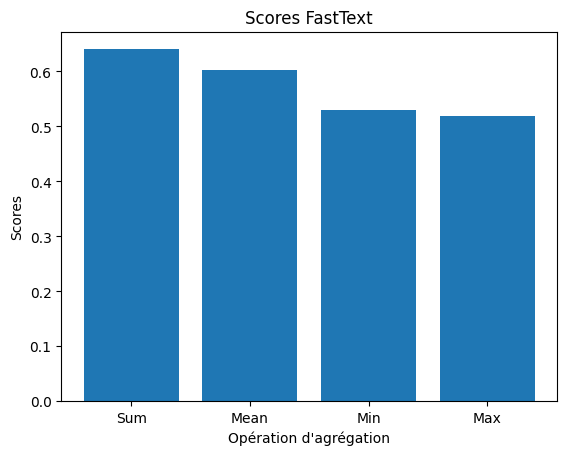

In [93]:
fig, ax = plt.subplots()

x = np.arange(len(m_names))
width = 0.2


plt.bar(f_names, ft_scores)
plt.xlabel('Opération d\'agrégation')
plt.ylabel('Scores')
plt.title('Scores FastText')
plt.show()

# Doc2vec

In [96]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

train_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data_train)]
d2v = Doc2Vec(train_documents)

2024-03-01 03:31:25,031 : INFO : collecting all words and their counts
2024-03-01 03:31:25,032 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2024-03-01 03:31:25,046 : INFO : PROGRESS: at example #10000, processed 20000 words (1616775 words/s), 9961 word types, 0 tags
2024-03-01 03:31:25,062 : INFO : collected 19875 word types and 20000 unique tags from a corpus of 20000 examples and 40000 words
2024-03-01 03:31:25,062 : INFO : Creating a fresh vocabulary
2024-03-01 03:31:25,067 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2 unique words (0.01% of original 19875, drops 19873)', 'datetime': '2024-03-01T03:31:25.067598', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
2024-03-01 03:31:25,068 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 20000 word corpus (50.00% of ori

In [104]:
labels_train1 = []
review_train1 = []
for (x,y) in data_train:
    review_train1.append(preprocess(x))
    labels_train1.append(y)
    
labels_test1 = []
review_test1 = []
for (x,y) in data_train:
    review_test1.append(preprocess(x))
    labels_test1.append(y)


train_text = review_train1
test_text = review_test1

y = labels_train1
y_test = labels_test1

X = [d2v.infer_vector(t.split()) for t in train_text]
X_test = [d2v.infer_vector(t.split()) for t in test_text]

In [107]:
lr = LogisticRegression()
lr.fit(X, y)

y_pred = lr.predict(X_test)

print('Doc2vec accuracy :', accuracy_score(y_pred, y_test))

Doc2vec accuracy : 0.502
